In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import re
from scipy.stats import chi2_contingency

In [ ]:
# load in the data
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")


In [ ]:
# load in the data
#reviews_df_raw = pd.read_json("../amazon_reviews.json",lines=True)
#reviews_pickle = reviews_df_raw.to_pickle('reviews_raw.pkl')
reviews_df_raw = pd.read_pickle('../rebekah-idea-testing/reviews_raw.pkl')

In [ ]:
# check shape 
print(train_df.shape)
print(val_df.shape)

(112768, 791)
(24164, 791)


In [ ]:
# drop the target and make its own variable
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']

In [6]:
X_val

,category,missing_price,item_rank,avg_rating,min_rating,percent_positive,percent_negative,avg_verified_reviewers,min_date,max_date,...,embedding_380,embedding_381,embedding_382,embedding_383,mean_sentiment_score,mean_complaint_similarity,mean_shipping_similarity,max_complaint_similarity,shipping_similarity_at_max_complaint,sentiment_score_at_max_complaint
328903,Sports & Outdoor Play,True,2261367.0,2.500000,4,0.500000,0.500000,1.000000,2014-02-15,2015-02-22,...,0.016948,-0.068813,-0.013661,0.101488,0.502364,0.135281,0.165143,0.195628,0.240833,0.005324
441635,Action Figures & Statues,True,541224.0,4.666667,5,1.000000,0.000000,1.000000,2016-12-25,2017-09-10,...,0.024212,0.010271,0.026576,0.056236,0.999246,0.056247,0.162368,0.135660,0.250080,0.999009
294770,Stuffed Animals & Plush Toys,False,1692453.0,1.000000,1,0.000000,1.000000,0.000000,2014-08-17,2014-08-17,...,0.034279,-0.071743,0.034022,0.143969,0.000270,0.203003,0.456016,0.203003,0.456016,0.000270
161637,Games,True,2187560.0,5.000000,5,1.000000,0.000000,1.000000,2011-07-17,2011-07-17,...,0.043803,-0.047145,-0.013756,0.120257,0.999848,0.118483,0.123220,0.118483,0.123220,0.999848
112229,Sports & Outdoor Play,True,2583901.0,5.000000,5,1.000000,0.000000,1.000000,2014-12-29,2014-12-29,...,0.023555,-0.021308,-0.010355,0.079722,0.999009,0.100356,0.161787,0.100356,0.161787,0.999009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520507,Baby & Toddler Toys,False,1069.0,4.518657,5,0.873134,0.074627,0.914179,2016-08-05,2018-09-13,...,-0.001130,-0.009788,0.021399,0.074541,0.868985,0.155356,0.218075,0.445087,0.287349,0.999855
523812,Dress Up & Pretend Play,False,139975.0,3.953488,5,0.674419,0.139535,0.930233,2016-12-22,2018-09-04,...,0.011493,0.027318,-0.016850,0.057224,0.779557,0.098794,0.190500,0.262011,0.509312,0.033752
536272,Toy Remote Control & Play Vehicles,False,71103.0,4.303030,5,0.818182,0.121212,1.000000,2017-01-06,2018-07-03,...,-0.011811,0.011275,-0.006499,0.060773,0.792642,0.065288,0.186122,0.335981,0.348223,0.999873
536984,"Tricycles, Scooters & Wagons",False,1318.0,3.850340,5,0.653061,0.224490,0.945578,2016-10-11,2018-09-26,...,-0.010304,0.029681,0.021493,0.050643,0.726797,0.093131,0.171684,0.290232,0.264554,0.009540


## Column Types

In [7]:
for df in (X_train, X_val):
    df['missing_price'] = df['missing_price'].astype(int)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}")

The shape of X_train: (112768, 790), X_val: (24164, 790)


In [8]:
for df in (X_train, X_val):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count'], axis=1, inplace=True)

In [9]:
for df in (X_train, X_val):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

In [10]:
for df in (X_train, X_val):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

In [11]:
# STEP 1: Identify embedding columns separately
summary_embedding_cols = [col for col in X_train.columns if re.match(r'^embed_\d+$', col)]
review_embedding_cols = [col for col in X_train.columns if re.match(r'^embedding_\d+$', col)]

# Extract review and summary embedding subsets
X_emb_review_train = X_train[review_embedding_cols].copy()
X_emb_summary_train = X_train[summary_embedding_cols].copy()

X_emb_review_val = X_val[review_embedding_cols].copy()
X_emb_summary_val = X_val[summary_embedding_cols].copy()

# Drop all embedding columns from X_train and X_val
X_train_nonemb = X_train.drop(columns=review_embedding_cols + summary_embedding_cols)
X_val_nonemb   = X_val.drop(columns=review_embedding_cols + summary_embedding_cols)

# STEP 2: Preprocess non-embedding features
categorical_cols = ['category']  
numeric_cols = [col for col in X_train_nonemb.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ]
)

X_train_nonemb_proc = preprocessor.fit_transform(X_train_nonemb)
X_val_nonemb_proc = preprocessor.transform(X_val_nonemb)

# STEP 3: Scale review and summary embeddings separately
scaler_review = StandardScaler()
X_emb_review_train_scaled = scaler_review.fit_transform(X_emb_review_train)
X_emb_review_val_scaled = scaler_review.transform(X_emb_review_val)

scaler_summary = StandardScaler()
X_emb_summary_train_scaled = scaler_summary.fit_transform(X_emb_summary_train)
X_emb_summary_val_scaled = scaler_summary.transform(X_emb_summary_val)

# STEP 4: PCA on each embedding type
pca_review = PCA(n_components=50, svd_solver='auto', random_state=42)
X_emb_review_train_reduced = pca_review.fit_transform(X_emb_review_train_scaled)
X_emb_review_val_reduced = pca_review.transform(X_emb_review_val_scaled)

pca_summary = PCA(n_components=10, svd_solver='auto', random_state=42)
X_emb_summary_train_reduced = pca_summary.fit_transform(X_emb_summary_train_scaled)
X_emb_summary_val_reduced = pca_summary.transform(X_emb_summary_val_scaled)

# STEP 5: VIF filtering
vif_feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)
X_df_for_vif = pd.DataFrame(X_train_nonemb_proc, columns=vif_feature_names)

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df_for_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df_for_vif.values, i)
                       for i in range(X_df_for_vif.shape[1])]
    
    if vif_data["VIF"].max() <= 10:
        break

    drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
    X_df_for_vif = X_df_for_vif.drop(columns=[drop_feature])

# Align validation with VIF-filtered features
X_val_nonemb_proc_df = pd.DataFrame(X_val_nonemb_proc, columns=vif_feature_names)
X_val_nonemb_filtered = X_val_nonemb_proc_df[X_df_for_vif.columns]

# STEP 6: Final feature names
final_feature_names = (
    X_df_for_vif.columns.tolist() +
    [f"pca_review_emb_{i}" for i in range(X_emb_review_train_reduced.shape[1])] +
    [f"pca_summary_emb_{i}" for i in range(X_emb_summary_train_reduced.shape[1])]
)

# STEP 7: Final data matrices
X_train_final_df = pd.DataFrame(
    np.hstack([X_df_for_vif.values, X_emb_review_train_reduced, X_emb_summary_train_reduced]),
    columns=final_feature_names
)

X_val_final_df = pd.DataFrame(
    np.hstack([X_val_nonemb_filtered.values, X_emb_review_val_reduced, X_emb_summary_val_reduced]),
    columns=final_feature_names
)


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping review_span with VIF = inf


In [12]:
X_train_final_df1 = X_train_final_df
X_val_final_df1 = X_val_final_df

## Generate Feature Processor Class After Those Preprocessing Steps:

In [13]:
class FeatureProcessor:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.preprocessor = None
        self.scaler_emb = None
        self.pca = None

        self.vif_keep_columns = None
        self.final_feature_names = None
        self.embedding_cols = None
        self.preproc_feature_names = None

    def _preprocess_dates_and_flags(self, df):
        df = df.copy()

        if 'max_date' in df.columns and 'min_date' in df.columns:
            df['review_span'] = (df['max_date'] - df['min_date']).dt.days
            df.drop(['min_date', 'max_date'], axis=1, inplace=True)

        if 'missing_price' in df.columns:
            df['missing_price'] = df['missing_price'].astype(int)

        if 'product_lifespan' in df.columns:
            df['product_lifespan_days'] = df['product_lifespan'].dt.days
            df.drop('product_lifespan', axis=1, inplace=True)

        drop_cols = [c for c in ['percent_positive', 'percent_negative', 'unique_reviewer_count'] if c in df.columns]
        df.drop(columns=drop_cols, errors='ignore', inplace=True)

        return df

    def fit(self, X_raw, skip_vif=False):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        self.review_cols = [col for col in X_raw.columns if re.match(r'^embed_\d+$', col)]
        self.summary_cols = [col for col in X_raw.columns if re.match(r'^embedding_\d+$', col)]

        # Select columns for each embedding type
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]
        X_emb = X_raw[self.review_cols + self.summary_cols]

        # Everything else
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Fit ColumnTransformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.categorical_cols),
            ]
        )
        X_nonemb_proc = self.preprocessor.fit_transform(X_nonemb)
        self.preproc_feature_names = (
            self.numeric_cols +
            list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))
        )

        # VIF filtering
        if not skip_vif:
            X_vif = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            while True:
                vif_data = pd.DataFrame()
                vif_data["feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                                   for i in range(X_vif.shape[1])]
                if vif_data["VIF"].max() <= 10:
                    break
                drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
                X_vif = X_vif.drop(columns=[drop_feature])
            self.vif_keep_columns = X_vif.columns.tolist()
        else:
            X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            X_vif = X_nonemb_df[self.vif_keep_columns]

        # Scale and reduce embeddings
        self.scaler_emb = StandardScaler()
        X_emb_scaled = self.scaler_emb.fit_transform(X_emb)

        self.pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
        X_emb_reduced = self.pca.fit_transform(X_emb_scaled)

        # Final DataFrame
        self.final_feature_names = self.vif_keep_columns + [f'pca_emb_{i}' for i in range(X_emb_reduced.shape[1])]
        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

    def transform(self, X_raw):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embeddings
        self.embedding_cols = self.review_cols + self.summary_cols
        X_emb = X_raw[self.embedding_cols]
        X_nonemb = X_raw.drop(columns=self.embedding_cols)

        # Transform non-embedding
        X_nonemb_proc = self.preprocessor.transform(X_nonemb)
        X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
        X_vif = X_nonemb_df[self.vif_keep_columns]

        # Transform embeddings
        X_emb_scaled = self.scaler_emb.transform(X_emb)
        X_emb_reduced = self.pca.transform(X_emb_scaled)

        return pd.DataFrame(np.hstack([X_vif.values, X_emb_reduced]), columns=self.final_feature_names)

In [14]:
class FeatureProcessor:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

        self.preprocessor = None

        self.scaler_review = None
        self.scaler_summary = None

        self.pca_review = None
        self.pca_summary = None

        self.vif_keep_columns = None
        self.final_feature_names = None

        self.review_cols = None
        self.summary_cols = None

        self.preproc_feature_names = None

    def _preprocess_dates_and_flags(self, df):
        df = df.copy()

        if 'max_date' in df.columns and 'min_date' in df.columns:
            df['review_span'] = (df['max_date'] - df['min_date']).dt.days
            df.drop(['min_date', 'max_date'], axis=1, inplace=True)

        if 'missing_price' in df.columns:
            df['missing_price'] = df['missing_price'].astype(int)

        if 'product_lifespan' in df.columns:
            df['product_lifespan_days'] = df['product_lifespan'].dt.days
            df.drop('product_lifespan', axis=1, inplace=True)

        drop_cols = [c for c in ['percent_positive', 'percent_negative', 'unique_reviewer_count'] if c in df.columns]
        df.drop(columns=drop_cols, errors='ignore', inplace=True)

        return df

    def fit(self, X_raw, skip_vif=False):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embedding columns
        self.review_cols = [col for col in X_raw.columns if re.match(r'^embed_\d+$', col)]
        self.summary_cols = [col for col in X_raw.columns if re.match(r'^embedding_\d+$', col)]

        # Extract embeddings separately
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]

        # Non-embedding columns
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Fit ColumnTransformer on non-embedding features
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), self.categorical_cols),
            ]
        )
        X_nonemb_proc = self.preprocessor.fit_transform(X_nonemb)
        self.preproc_feature_names = (
            self.numeric_cols +
            list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_cols))
        )

        # VIF filtering
        if not skip_vif:
            X_vif = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            while True:
                vif_data = pd.DataFrame()
                vif_data["feature"] = X_vif.columns
                vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                                   for i in range(X_vif.shape[1])]
                if vif_data["VIF"].max() <= 10:
                    break
                drop_feature = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping {drop_feature} with VIF = {vif_data['VIF'].max():.2f}")
                X_vif = X_vif.drop(columns=[drop_feature])
            self.vif_keep_columns = X_vif.columns.tolist()
        else:
            X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
            X_vif = X_nonemb_df[self.vif_keep_columns]

        # Scale embeddings separately
        self.scaler_review = StandardScaler()
        X_emb_review_scaled = self.scaler_review.fit_transform(X_emb_review)

        self.scaler_summary = StandardScaler()
        X_emb_summary_scaled = self.scaler_summary.fit_transform(X_emb_summary)

        # PCA separately
        self.pca_review = PCA(n_components=50, svd_solver='auto', random_state=42)
        X_emb_review_reduced = self.pca_review.fit_transform(X_emb_review_scaled)

        self.pca_summary = PCA(n_components=10, svd_solver='auto', random_state=42)
        X_emb_summary_reduced = self.pca_summary.fit_transform(X_emb_summary_scaled)

        # Compose final feature names with clear distinction
        self.final_feature_names = (
            self.vif_keep_columns +
            [f'pca_review_emb_{i}' for i in range(X_emb_review_reduced.shape[1])] +
            [f'pca_summary_emb_{i}' for i in range(X_emb_summary_reduced.shape[1])]
        )

        # Return combined DataFrame
        return pd.DataFrame(
            np.hstack([X_vif.values, X_emb_review_reduced, X_emb_summary_reduced]),
            columns=self.final_feature_names
        )

    def transform(self, X_raw):
        X_raw = self._preprocess_dates_and_flags(X_raw)

        # Separate embedding columns
        X_emb_review = X_raw[self.review_cols]
        X_emb_summary = X_raw[self.summary_cols]
        X_nonemb = X_raw.drop(columns=self.review_cols + self.summary_cols)

        # Transform non-embedding features
        X_nonemb_proc = self.preprocessor.transform(X_nonemb)
        X_nonemb_df = pd.DataFrame(X_nonemb_proc, columns=self.preproc_feature_names)
        X_vif = X_nonemb_df[self.vif_keep_columns]

        # Transform embeddings separately
        X_emb_review_scaled = self.scaler_review.transform(X_emb_review)
        X_emb_review_reduced = self.pca_review.transform(X_emb_review_scaled)

        X_emb_summary_scaled = self.scaler_summary.transform(X_emb_summary)
        X_emb_summary_reduced = self.pca_summary.transform(X_emb_summary_scaled)

        # Return combined DataFrame
        return pd.DataFrame(
            np.hstack([X_vif.values, X_emb_review_reduced, X_emb_summary_reduced]),
            columns=self.final_feature_names
        )


In [15]:
# Final vif columns
final_vif_columns = X_df_for_vif.columns.tolist()

print(f"Final vif columns: {final_vif_columns}")

processor = FeatureProcessor(numeric_cols, categorical_cols)
processor.vif_keep_columns = final_vif_columns

X_train_final_df = processor.fit(train_df.drop(columns=['match'], axis=1), skip_vif=True)
X_val_final_df   = processor.transform(val_df.drop(columns=['match'], axis=1))

Final vif columns: ['missing_price', 'item_rank', 'avg_rating', 'min_rating', 'avg_verified_reviewers', 'num_bots_per_asin', 'avg_reviews_per_day', 'reviews_per_product', 'avg_review_length_words', 'mean_sentiment_score', 'mean_complaint_similarity', 'mean_shipping_similarity', 'max_complaint_similarity', 'shipping_similarity_at_max_complaint', 'sentiment_score_at_max_complaint', 'product_lifespan_days', 'category_Action Figures & Statues', 'category_Arts & Crafts', 'category_Baby & Toddler Toys', 'category_Building Toys', 'category_Dolls & Accessories', 'category_Dress Up & Pretend Play', 'category_Games', 'category_Grown-Up Toys', 'category_Hobbies', "category_Kids' Electronics", "category_Kids' Furniture, Dcor & Storage", 'category_Learning & Education', 'category_Novelty & Gag Toys', 'category_Party Supplies', 'category_Puppets', 'category_Puzzles', 'category_Sports & Outdoor Play', 'category_Stuffed Animals & Plush Toys', 'category_Toy Remote Control & Play Vehicles', 'category_Tr

In [16]:
# Save preprocessed columns:
X_train_final_df.to_pickle("X_train_final_df.pkl")
X_val_final_df.to_pickle("X_val_final_df.pkl")

In [17]:
# Load preprocessed columns
X_train_final_df = pd.read_pickle("X_train_final_df.pkl")
X_val_final_df   = pd.read_pickle("X_val_final_df.pkl")

# Model Training

In [18]:
class ModelEvaluator:
    def __init__(self, model, average='binary', display_labels=None):
        self.model = model
        self.average = average
        self.display_labels = display_labels

    def evaluate_classification(self, y_true, y_pred):
        prec = precision_score(y_true, y_pred, average=self.average)
        rec  = recall_score   (y_true, y_pred, average=self.average)
        f1   = f1_score       (y_true, y_pred, average=self.average)

        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {rec:.3f}")
        print(f"F1-score:  {f1:.3f}\n")

        print("Classification Report:\n", classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=self.display_labels)
        fig, ax = plt.subplots(figsize=(5, 5))
        disp.plot(ax=ax, cmap='Blues')
        ax.set_title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_names, top_n=30):
        if hasattr(self.model, "feature_importances_"):
            # Tree-based models
            importances = self.model.feature_importances_
            indices = importances.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), importances[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Feature Importances (Tree-based)")
            plt.tight_layout()
            plt.show()
    
        elif hasattr(self.model, "coef_"):
            # Linear models like Logistic Regression
            coefs = self.model.coef_.ravel()
            abs_coefs = np.abs(coefs)
            indices = abs_coefs.argsort()[::-1][:top_n]
    
            plt.figure(figsize=(10, 6))
            plt.barh(range(top_n), coefs[indices][::-1])
            plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
            plt.title("Top Logistic Regression Coefficients")
            plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
            plt.tight_layout()
            plt.show()
    
        else:
            print("This model does not support feature importance or coefficients.")



    def fit_and_evaluate(self, X_train, y_train, X_val, y_val):
        print("Training model:")
        self.model.fit(X_train, y_train)

        print("Training Performance:")
        y_train_pred = self.model.predict(X_train)
        self.evaluate_classification(y_train, y_train_pred)

        print("Validation Performance:")
        y_val_pred = self.model.predict(X_val)
        self.evaluate_classification(y_val, y_val_pred)

        return self.model


## Logistic Regression

In [ ]:
# initialize logistic regression
logreg = LogisticRegression(solver='saga', penalty='l1', class_weight='balanced', random_state=42, max_iter=5000)

False Positive Analysis

In [20]:
def make_false_positive_df(X_validation_df, y_val, model, asin_file_path):
    """
    Creates a DataFrame of false positives (predicted 1 but true label is 0)
    from a classification model's validation predictions, merged with ASIN data.

    Parameters:
        X_validation_df (pd.DataFrame): Validation feature set.
        y_val (pd.Series): True labels with index corresponding to ASINs.
        model (sklearn-like model): Trained model with a `.predict()` method.
        asin_file_path (str): Path to a Parquet file containing ASIN metadata, indexed by ASIN.

    Returns:
        pd.DataFrame: False positive samples merged with ASIN metadata.
    """
    # Predict labels
    preds=model.fit(X_train_final_df,y_train)
    preds = model.predict(X_validation_df)
    probs = model.predict_proba(X_validation_df)[:,1]

    # Create DataFrame with predictions and true labels
    fp_df = X_validation_df.copy()
    fp_df['preds'] = preds
    fp_df['proba'] = probs
    fp_df['original_index'] = y_val.index
    fp_df['y_true'] = y_val.values

    # Load ASIN metadata
    asin_df = pd.read_parquet(asin_file_path)
    asin_df = asin_df.copy()
    asin_df['index'] = asin_df.index  # Preserve index for merging

    # Merge using the original indices (which should align with asin_df's index)
    fp_df = fp_df.merge(asin_df, left_on='original_index', right_on='index')

    # Filter to false positives only: true label 0, predicted 1
    false_positives = fp_df[(fp_df['y_true'] == 0) & (fp_df['preds'] == 1)]

    return false_positives, fp_df



In [21]:
false_positives, full_val_df = make_false_positive_df(X_val_final_df, y_val, logreg, '/Users/rebekaheichberg/Desktop/git-re/summer-2025-safeify/Data/asins_in_splits/validationA_asins.parquet')

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
# check review text to see if negative words appear
full_val_df.sample(10)

,missing_price,item_rank,avg_rating,min_rating,avg_verified_reviewers,num_bots_per_asin,avg_reviews_per_day,reviews_per_product,avg_review_length_words,mean_sentiment_score,...,pca_summary_emb_6,pca_summary_emb_7,pca_summary_emb_8,pca_summary_emb_9,preds,proba,original_index,y_true,asin,index
8080,1.049033,-1.123469,-1.137692,-1.708671,-3.502549,-0.147503,-0.482579,-0.197906,12.114345,0.705521,...,4.884075,-2.508687,-0.495394,-0.018624,1,0.554010,491611,0,B017RLNDKS,491611
9949,1.049033,-0.452851,0.040525,0.382759,0.485576,-0.147503,-0.180465,-0.080473,0.095017,0.318306,...,-1.484752,-3.787083,1.233510,1.472216,1,0.638485,159342,0,B004LPEIHG,159342
12974,1.049033,0.970015,-2.101687,-2.754386,0.485576,-0.147503,-0.488591,-0.197906,0.611950,-2.628101,...,-1.336632,2.761297,-4.442184,0.580429,0,0.024964,258885,0,B00AOZVGOK,258885
11698,1.049033,-0.525561,-2.402936,-0.662956,-0.262198,-0.147503,-0.276637,0.022280,-0.283753,-1.576993,...,-0.551001,1.474049,1.508430,-1.778880,0,0.450101,393762,0,B00O449VG2,393762
4672,-0.953258,-0.928971,0.790299,0.382759,0.485576,-0.147503,0.733557,-0.153869,-0.784937,0.717107,...,-0.132853,-0.393354,-1.179350,0.815616,0,0.049211,210381,0,B006KH6G82,210381
12867,1.049033,0.668280,0.790299,0.382759,0.485576,-0.147503,-0.560435,-0.197906,0.144373,0.700078,...,0.451656,-1.151499,2.989899,-1.405141,0,0.020458,354309,0,B00JEZOJZY,354309
869,1.049033,0.015765,-0.173697,-0.662956,0.485576,-0.147503,-0.365201,-0.197906,-0.790782,0.718429,...,1.559034,-2.793001,-2.541305,1.225710,0,0.072073,172258,0,B004ZY9JMC,172258
274,1.049033,0.643190,0.790299,0.382759,0.485576,-0.147503,-0.546808,-0.197906,0.284646,0.719818,...,-1.984940,-7.453947,-1.131959,-1.598797,0,0.495388,465548,0,B0139S33HQ,465548
17432,-0.953258,-0.213608,-3.065682,-3.800100,0.485576,-0.147503,-0.562160,-0.183227,-0.334894,-2.623559,...,4.228981,3.230451,-1.472728,-1.736955,1,0.541090,358542,0,B00JW25B4C,358542
10984,-0.953258,-0.270507,0.067302,0.382759,0.485576,-0.147503,-0.070222,-0.153869,-0.147863,-0.116965,...,4.235853,-1.471334,-0.229641,2.916326,0,0.031893,121562,0,B002PSS6JC,121562


In [23]:
# check review text of true negatives to see how negative words show up in the reviews
full_val_df[full_val_df['y_true']==0].sample(10)

,missing_price,item_rank,avg_rating,min_rating,avg_verified_reviewers,num_bots_per_asin,avg_reviews_per_day,reviews_per_product,avg_review_length_words,mean_sentiment_score,...,pca_summary_emb_6,pca_summary_emb_7,pca_summary_emb_8,pca_summary_emb_9,preds,proba,original_index,y_true,asin,index
17286,-0.953258,-0.884562,-0.495028,0.382759,-0.843799,-0.147503,0.084291,-0.168548,-0.556993,-0.393502,...,0.295184,2.783339,-2.785333,-0.620961,1,0.889528,478539,0,B015OOWP8G,478539
10097,1.049033,1.618283,-3.065682,-3.800100,0.485576,-0.147503,0.084291,-0.197906,-0.720645,-2.627894,...,-0.565248,-1.469615,-7.013055,-1.811754,0,0.090313,223253,0,B007E90CZS,223253
13024,1.049033,0.537827,0.308301,0.382759,-1.508487,-0.147503,-0.209585,-0.183227,10.828508,-0.963250,...,-1.128718,4.617782,-3.438055,-0.754169,0,0.012899,380504,0,B00MJ8IXZU,380504
64,-0.953258,-0.482042,0.211901,0.382759,0.485576,-0.147503,-0.038007,-0.139190,-0.215662,0.061983,...,2.995991,2.537100,0.520575,4.495321,0,0.115175,57685,0,B000WEAA18,57685
10485,1.049033,-0.925136,-0.275170,0.382759,-0.563931,-0.147503,0.200153,0.066317,-0.260451,-0.653132,...,-2.055685,1.329436,0.652751,-2.034030,0,0.102254,544293,0,B01GW7F24S,544293
6211,1.049033,-0.467598,-0.495028,0.382759,0.295665,-0.147503,0.804942,0.095675,-0.434532,-0.241781,...,-0.299848,-0.645805,0.492458,-0.181775,0,0.380459,293415,0,B00DDV5DM8,293415
10477,-0.953258,-0.896680,-1.137692,-1.708671,0.485576,-0.147503,0.084291,-0.197906,-0.182931,-2.627956,...,-2.176804,-5.603164,-2.256786,-1.683668,0,0.122737,21535,0,B000BQ4WDE,21535
9839,-0.953258,-0.577965,0.790299,0.382759,0.485576,-0.147503,-0.551792,-0.197906,-0.650508,0.717107,...,6.883973,3.390368,4.592475,2.077714,0,0.000327,385233,0,B00N5084VO,385233
8231,1.049033,0.215332,0.790299,0.382759,-3.502549,-0.147503,-0.559091,-0.197906,-0.323205,0.488037,...,0.896498,2.699180,0.357500,0.167787,1,0.992947,66480,0,B00139HWCQ,66480
15669,1.049033,-1.106477,0.604468,0.382759,0.485576,10.207551,1.078125,1.005777,-0.358132,0.589266,...,1.594838,-0.953864,-1.585876,-2.696268,1,0.809624,500087,0,B019HP0N96,500087


In [24]:
def false_positive_category_concentration(false_positive_df):
    dummies = list(false_positive_df.columns[:-2])
    un_dummied = false_positive_df[dummies].idxmax(axis=1)
    un_dummied = un_dummied.str.replace('cat_', '', regex=False)
    return un_dummied.value_counts(normalize=True)
    

In [25]:
def false_positive_category_concentration(false_positive_df, dummy_prefix='category_'):
    """
    Calculates the normalized concentration of false positives across categories.

    Parameters:
        false_positive_df (pd.DataFrame): DataFrame of false positives with one-hot encoded category columns.
        dummy_prefix (str): Prefix used in the one-hot encoded category column names (default is 'cat_').

    Returns:
        pd.Series: Normalized value counts (proportions) for each original category.
    """
    # Automatically detect one-hot encoded category columns
    category_cols = [col for col in false_positive_df.columns if col.startswith(dummy_prefix)]

    if not category_cols:
        raise ValueError(f"No columns found with prefix '{dummy_prefix}'.")

    # Get the most likely category per row (based on the dummy with max value)
    top_category = false_positive_df[category_cols].idxmax(axis=1)

    # Remove prefix to get original category names
    top_category = top_category.str.replace(dummy_prefix, '', regex=False)

    # Return normalized frequency
    return top_category.value_counts(normalize=True)


In [26]:
false_positive_category_concentration(false_positives)

Dolls & Accessories                   0.204412
Arts & Crafts                         0.152390
Sports & Outdoor Play                 0.111397
Toy Remote Control & Play Vehicles    0.086765
Stuffed Animals & Plush Toys          0.081801
Baby & Toddler Toys                   0.059007
Learning & Education                  0.057537
Hobbies                               0.049632
Dress Up & Pretend Play               0.038787
Action Figures & Statues              0.036029
Building Toys                         0.032904
Novelty & Gag Toys                    0.024632
Kids' Electronics                     0.021691
Tricycles, Scooters & Wagons          0.020404
Puzzles                               0.010294
Grown-Up Toys                         0.005515
Party Supplies                        0.004228
Games                                 0.002574
Name: proportion, dtype: float64

<Axes: title={'center': 'Category Distribution: False Positives vs True Negatives'}>

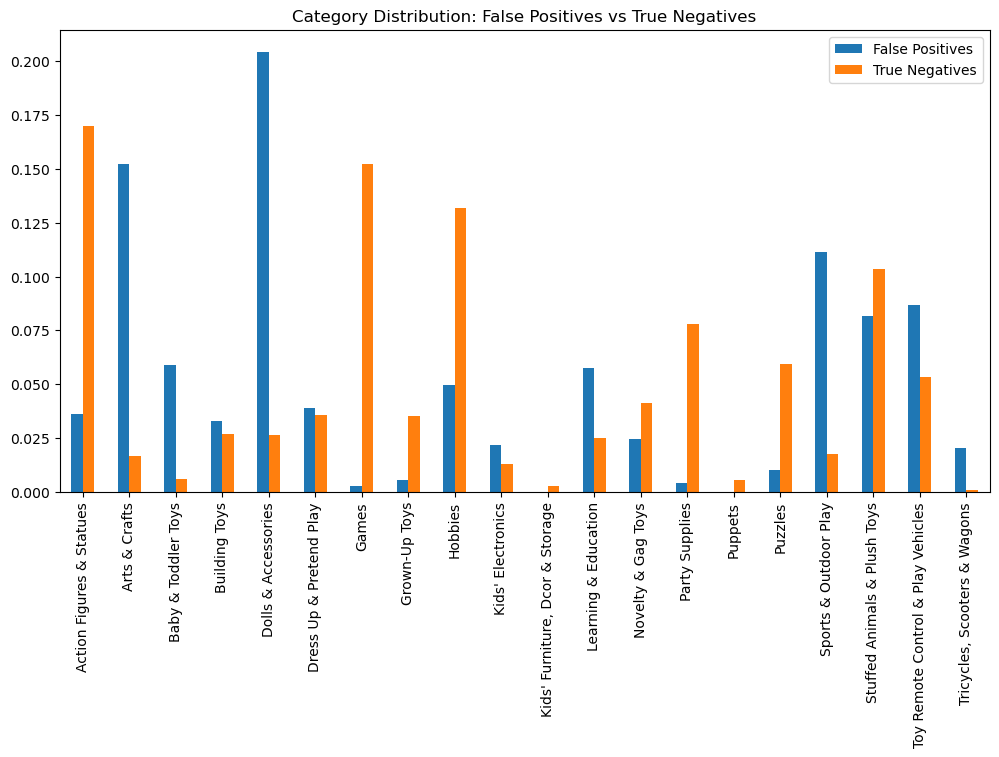

In [27]:
# Get normalized counts for each category in false positives
fp_cat_dist = false_positive_category_concentration(false_positives)

# Do the same for true negatives (TN): y_true = 0, preds = 0
tn_df = full_val_df[(full_val_df['y_true'] == 0) & (full_val_df['preds'] == 0)]
tn_cat_dist = false_positive_category_concentration(tn_df)

# Combine into a DataFrame for plotting
comparison_df = pd.DataFrame({
    'False Positives': fp_cat_dist,
    'True Negatives': tn_cat_dist
}).fillna(0)

# Plot
comparison_df.plot(kind='bar', figsize=(12,6), title='Category Distribution: False Positives vs True Negatives')


In [28]:
from scipy.stats import chi2_contingency

def compute_category_chi2(fp_df, tn_df, dummy_prefix='cat_'):
    # Step 1: Get category columns
    cat_cols = [col for col in fp_df.columns if col.startswith(dummy_prefix)]
    
    # Step 2: Convert back to category labels
    def get_cat_dist(df):
        cat_labels = df[cat_cols].idxmax(axis=1).str.replace(dummy_prefix, '', regex=False)
        return cat_labels.value_counts()
    
    fp_counts = get_cat_dist(fp_df)
    tn_counts = get_cat_dist(tn_df)

    # Step 3: Align index and fill missing categories with 0
    aligned = pd.concat([fp_counts, tn_counts], axis=1, keys=['FP', 'TN']).fillna(0)

    # Step 4: Ensure integer values
    aligned = aligned.astype(int)

    # Step 5: Create contingency table
    contingency = aligned.T.values

    # Step 6: Perform Chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency)

    return p, aligned


In [29]:
p, cat_table = compute_category_chi2(false_positives, tn_df, dummy_prefix='category_')

In [30]:
p

np.float64(0.0)

* Model is misclassifying certain categories as positive, even though they’re actually negative.
* Some categories are overrepresented in the false positives relative to the true negatives.
* This might indicate:

  * **Feature bias**: Certain features correlate with these categories and are driving the wrong predictions.
  * **Label issues**: These categories may be ambiguous or inconsistently labeled.
  * **Insufficient representation** in training data for those categories.

In [31]:
cat_table

,FP,TN
Dolls & Accessories,1112,486
Arts & Crafts,829,307
Sports & Outdoor Play,606,324
Toy Remote Control & Play Vehicles,472,991
Stuffed Animals & Plush Toys,445,1917
Baby & Toddler Toys,321,113
Learning & Education,313,463
Hobbies,270,2448
Dress Up & Pretend Play,211,660
Action Figures & Statues,196,3151


In [32]:
cat_table['FP_Rate'] = cat_table['FP'] / cat_table['FP'].sum()
cat_table['TN_Rate'] = cat_table['TN'] / cat_table['TN'].sum()
cat_table['Overrepresented_in_FP'] = cat_table['FP_Rate'] - cat_table['TN_Rate']
cat_table.sort_values('Overrepresented_in_FP', ascending=False).head(10)


,FP,TN,FP_Rate,TN_Rate,Overrepresented_in_FP
Dolls & Accessories,1112,486,0.204412,0.026185,0.178226
Arts & Crafts,829,307,0.152390,0.016541,0.135849
Sports & Outdoor Play,606,324,0.111397,0.017457,0.093940
Baby & Toddler Toys,321,113,0.059007,0.006088,0.052919
Toy Remote Control & Play Vehicles,472,991,0.086765,0.053394,0.033370
Learning & Education,313,463,0.057537,0.024946,0.032591
"Tricycles, Scooters & Wagons",111,18,0.020404,0.000970,0.019435
Kids' Electronics,118,241,0.021691,0.012985,0.008706
Building Toys,179,498,0.032904,0.026832,0.006073
Dress Up & Pretend Play,211,660,0.038787,0.035560,0.003226


False positives with high predicted probabilities could indicate:

- Confusing features
- Potential label noise
- Overconfident model predictions

Text(0, 0.5, 'Count')

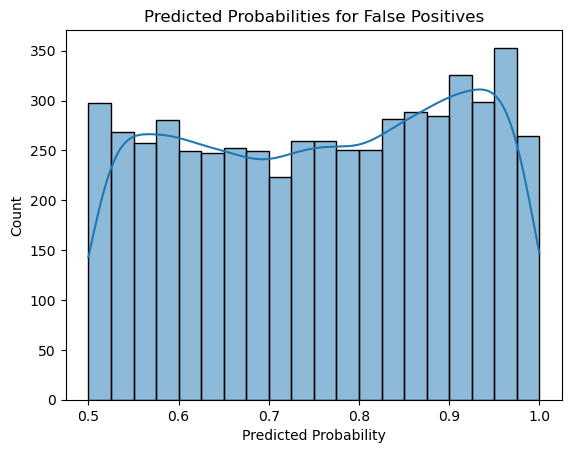

In [33]:
# Histogram of probabilities
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(false_positives['proba'], bins=20, kde=True)
plt.title("Predicted Probabilities for False Positives")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
